# Лабораторная №1 - Нейронная сеть прямого распространения

## Решаемая задача: распознавание рукописных символов

### Подготовка данных
В качестве датасета используется emnist-letters. Он содержит 26 сбалансированных классов - рукописные буквы латинского алфавита (строчные и прописные) в градациях серого, 28x28 пикселей.

Прочитаем данные в ndarray с помощью idx2numpy

In [56]:
import idx2numpy
import numpy as np

x_train = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-train-images-idx3-ubyte')).astype('float32')
y_train = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-train-labels-idx1-ubyte'))

x_test = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-test-images-idx3-ubyte')).astype('float32')
y_test = np.array(idx2numpy.convert_from_file('./data/emnist/emnist-letters-test-labels-idx1-ubyte'))

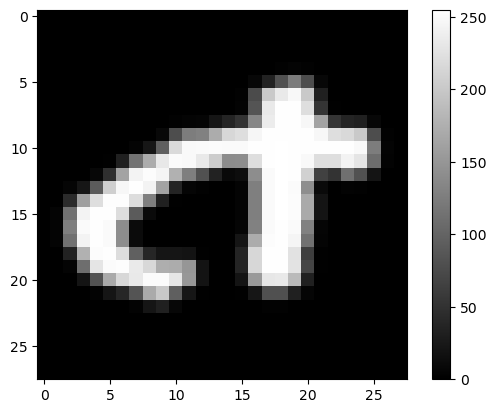

In [57]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_train[100], cmap='gray')
plt.colorbar()
plt.grid(False)

Изначально изображения в не очень удобном формате: цвет каждого пикселя изменяется от 0 до 255, отражены и перевёрнуты. 

Чтобы расчеты были эффективнее, разделим все значения на максимальное. Также отразим и перевернем изображения.

In [58]:
x_train /= 255
x_test /= 255

x_train = np.fliplr(x_train)
x_test = np.fliplr(x_test)

x_train = np.rot90(x_train, k=3, axes=(1, 2))
x_test = np.rot90(x_test, k=3, axes=(1, 2))

Также преобразуем каждое изображение из матрицы 28x28 в строки из 784 элементов

In [59]:
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

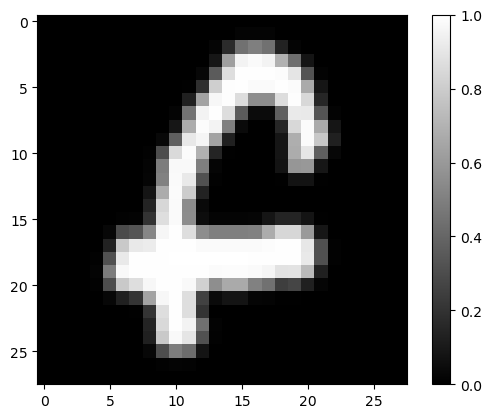

In [60]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_train[100].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.grid(False)

В массивах правильных ответов из каждого значения вычтем 1, чтобы удобнее было индексировать

In [61]:
y_train -= 1
y_test -= 1

Изначальную тестовую выборку разделим пополам: первую будем использовать для тестирования, вторую для валидации

In [262]:
indices = np.random.permutation(len(x_test))
split_idx = len(x_test) // 2
val_indices, test_indices = indices[:split_idx], indices[split_idx:]

x_valid, y_valid = x_test[val_indices], y_test[val_indices]
x_test_small, y_test_small = x_test[test_indices], y_test[test_indices]

### Реализация сети

Класс Network - представляет сеть прямого распространения с произвольными числом слоёв, количеством нейронов в каждом, функциями активации (по умолчанию для скрытых слоёв ReLU, для выходного слоя softmax)

In [68]:
import time

def ReLU(x, derivative=False):
    return x * (x > 0) if not derivative else x > 0


def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

class Network:

    def __init__(self, sizes, activation_func=ReLU, output_func=softmax):
        self.sizes = sizes
        self.activation_func = activation_func
        self.output_func = output_func
        # self._norm_init()
        # self._xavier_init()
        self._he_init()

    def _norm_init(self):
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            self.weights.append(0 + 0.5 * np.random.randn(self.sizes[i-1], self.sizes[i]))
            self.biases.append(np.zeros((1, self.sizes[i])))

    def _xavier_init(self):
        
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            left, right = self.sizes[i-1], self.sizes[i]
            limit = np.sqrt(6 / (left + right))
            self.weights.append(np.random.uniform(-limit, limit, size=(left, right)))
            self.biases.append(np.zeros((1, self.sizes[i])))
            
    def _he_init(self):
        self.weights = []
        self.biases = []
        self.activations = []
        self.deltaW = []
        self.deltaB = []
        
        for i in range(1, len(self.sizes)):
            left, right = self.sizes[i-1], self.sizes[i]
            limit = np.sqrt(2 / left)
            self.weights.append(np.random.uniform(-limit, limit, size=(left, right)))
            self.biases.append(np.zeros((1, self.sizes[i])))
       
    def _forward(self, x):
        self.activations = [np.array(x).reshape(1, len(x))]
        
        for i in range(len(self.sizes)-2):
            self.activations.append(self.activation_func(np.dot(self.activations[-1], self.weights[i]) + self.biases[i]))

        self.activations.append(self.output_func(np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]))
        
        return self.activations[-1]

    def _backprop(self, y_valid):
        self.deltaW = []
        self.deltaB = []
        error = self.activations[len(self.sizes)-1] - y_valid
        
        for i in range(len(self.sizes)-2, -1, -1):
            self.deltaW.insert(0, np.dot(self.activations[i].T, error))
            self.deltaB.insert(0, np.sum(error, axis=0, keepdims=True))
            error = np.dot(error, self.weights[i].T) * ReLU(self.activations[i], derivative=True)

    def _update_params(self, learning_rate):
        
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.deltaW[i]
            self.biases[i] -= learning_rate * self.deltaB[i]
        
    def _onehot(self, y):
        one_hot = np.zeros((1, self.sizes[-1]))
        one_hot[0, y] = 1
        return one_hot
        
    def fit(self, 
            x_train, y_train, x_test, y_test, epochs, learning_rate, 
            growth_rate=2, patience=2, epsilon=0.005, print_all=True):
        time_data = []
        loss_data = []
        acc_data = []
        start = time.time()
        
        last_loss = float('inf')  # Лучший зафиксированный loss
        patience_counter = 0  # Счетчик эпох без улучшения
        
        for epoch in range(epochs):
            total_loss = 0
            epoch_start = time.time()
            
            for x, y in zip(x_train, y_train):
                y_onehot = self._onehot(y)
                self._forward(x)
                self._backprop(y_onehot)
                self._update_params(learning_rate)
                self._forward(x)
                output = self.activations[-1]
                loss = -np.sum(y_onehot * np.log(output + 1e-8))
                total_loss += loss
            avg_loss = total_loss / len(x_train)
            loss_data.append(avg_loss)
            accuracy = self.test(x_test, y_test)
            acc_data.append(accuracy)
            
            if print_all or (epoch + 1) % 5 == 0:
                print(f"====================================\n"
                      f"Epoch {epoch + 1}/{epochs}\nLoss: {avg_loss:.4f}")
                print(f'Accuracy: {accuracy:.2f}%')
            time_data.append(time.time() - epoch_start)
            
            if avg_loss < last_loss:
                if last_loss - avg_loss < epsilon:
                    patience_counter += 1
                last_loss = avg_loss
            elif avg_loss - last_loss > epsilon:
                learning_rate *= 0.8
                print(f'⚠️ LR уменьшен на 20%: {learning_rate}')
            
            if patience_counter >= patience:
                patience_counter = 0
                learning_rate *= growth_rate
                print(f'⚠️ LR увеличен в {growth_rate} раза: {learning_rate}')
            
        print(f'====================================\n'
              f'Total time: {time.time() - start:.2f}')
        
        return time_data, loss_data, acc_data
    
    def test(self, x_test, y_test):
        correct = 0
        for x, y in zip(x_test, y_test):
            prediction = self.predict(x)
            if prediction == y:
                correct += 1

        return correct / len(y_test) * 100

    def predict(self, x):
        self._forward(x)
        return np.argmax(self.activations[-1])

### Обучение

Начнем с одного скрытого слоя с 32 нейронами

In [224]:
input_ = x_train.shape[1]
num_classes = len(np.unique(y_train))
experiment_data = {}

In [263]:
model1 = Network([input_, 32, num_classes])
experiment_data[32] = (model1, model1.fit(x_train, y_train, x_test_small, y_test_small, epochs=20, learning_rate=0.01))

Epoch 1/20
Loss: 0.3472
Accuracy: 75.79%
Epoch 2/20
Loss: 0.2338
Accuracy: 76.97%
Epoch 3/20
Loss: 0.2147
Accuracy: 77.36%
Epoch 4/20
Loss: 0.1999
Accuracy: 78.10%
Epoch 5/20
Loss: 0.1897
Accuracy: 78.65%
Epoch 6/20
Loss: 0.1837
Accuracy: 79.48%
Epoch 7/20
Loss: 0.1807
Accuracy: 79.09%
Epoch 8/20
Loss: 0.1784
Accuracy: 79.01%
⚠️ LR увеличен в 2 раза: 0.02
Epoch 9/20
Loss: 0.1571
Accuracy: 75.22%
Epoch 10/20
Loss: 0.1789
Accuracy: 73.87%
⚠️ LR уменьшен на 20%: 0.016
Epoch 11/20
Loss: 0.1859
Accuracy: 76.47%
⚠️ LR уменьшен на 20%: 0.0128
Epoch 12/20
Loss: 0.1952
Accuracy: 78.86%
⚠️ LR уменьшен на 20%: 0.01024
Epoch 13/20
Loss: 0.2105
Accuracy: 80.05%
⚠️ LR уменьшен на 20%: 0.008192000000000001
Epoch 14/20
Loss: 0.2292
Accuracy: 81.33%
⚠️ LR уменьшен на 20%: 0.0065536000000000014
Epoch 15/20
Loss: 0.2498
Accuracy: 82.46%
⚠️ LR уменьшен на 20%: 0.005242880000000002
Epoch 16/20
Loss: 0.2696
Accuracy: 83.07%
⚠️ LR уменьшен на 20%: 0.004194304000000002
Epoch 17/20
Loss: 0.2890
Accuracy: 83.38

Попробуем увеличивать число нейронов

In [264]:
model2 = Network([input_, 64, num_classes])
experiment_data[64] = (model2, model2.fit(x_train, y_train, x_test_small, y_test_small, epochs=20, learning_rate=0.01, print_all=False))

Epoch 5/20
Loss: 0.1123
Accuracy: 83.72%
⚠️ LR увеличен в 2 раза: 0.02
⚠️ LR уменьшен на 20%: 0.016
⚠️ LR уменьшен на 20%: 0.0128
Epoch 10/20
Loss: 0.1155
Accuracy: 83.00%
⚠️ LR уменьшен на 20%: 0.01024
⚠️ LR уменьшен на 20%: 0.008192000000000001
⚠️ LR уменьшен на 20%: 0.0065536000000000014
⚠️ LR уменьшен на 20%: 0.005242880000000002
⚠️ LR уменьшен на 20%: 0.004194304000000002
Epoch 15/20
Loss: 0.1786
Accuracy: 86.65%
⚠️ LR уменьшен на 20%: 0.003355443200000002
⚠️ LR уменьшен на 20%: 0.0026843545600000016
⚠️ LR уменьшен на 20%: 0.0021474836480000013
⚠️ LR уменьшен на 20%: 0.0017179869184000011
⚠️ LR уменьшен на 20%: 0.001374389534720001
Epoch 20/20
Loss: 0.2233
Accuracy: 87.86%
⚠️ LR уменьшен на 20%: 0.001099511627776001
Total time: 229.69


In [265]:
model3 = Network([input_, 128, num_classes])
experiment_data[128] = (model3, model3.fit(x_train, y_train, x_test_small, y_test_small, epochs=20, learning_rate=0.01, print_all=False))

Epoch 5/20
Loss: 0.0688
Accuracy: 85.89%
⚠️ LR увеличен в 2 раза: 0.02
Epoch 10/20
Loss: 0.0603
Accuracy: 81.15%
⚠️ LR уменьшен на 20%: 0.016
⚠️ LR уменьшен на 20%: 0.0128
⚠️ LR уменьшен на 20%: 0.01024
⚠️ LR уменьшен на 20%: 0.008192000000000001
⚠️ LR уменьшен на 20%: 0.0065536000000000014
Epoch 15/20
Loss: 0.0860
Accuracy: 87.76%
⚠️ LR уменьшен на 20%: 0.005242880000000002
⚠️ LR уменьшен на 20%: 0.004194304000000002
⚠️ LR уменьшен на 20%: 0.003355443200000002
⚠️ LR уменьшен на 20%: 0.0026843545600000016
⚠️ LR уменьшен на 20%: 0.0021474836480000013
Epoch 20/20
Loss: 0.1164
Accuracy: 89.12%
⚠️ LR уменьшен на 20%: 0.0017179869184000011
Total time: 369.78


In [ ]:
model4 = Network([input_, 256, num_classes])
experiment_data[256] = (model4, model4.fit(x_train, y_train, x_test_small, y_test_small, epochs=20, learning_rate=0.01, print_all=False))

Добавим ещё один слой

In [ ]:
model5 = Network([input_, 64, 32, num_classes])
experiment_data[64*32] = (model5, model5.fit(x_train, y_train, x_test_small, y_test_small, epochs=20, learning_rate=0.01, print_all=False))

In [ ]:
model6 = Network([input_, 128, 64, num_classes])
experiment_data[128*64] = (model6, model6.fit(x_train, y_train, x_test_small, y_test_small, epochs=20, learning_rate=0.01, print_all=False))

In [ ]:
model7 = Network([input_, 256, 128, num_classes])
experiment_data[256*128] = (model7, model7.fit(x_train, y_train, x_test_small, y_test_small, epochs=20, learning_rate=0.01, print_all=False))

In [ ]:
model8 = Network([input_, 512, 256, num_classes])
experiment_data[512*256] = (model8, model8.fit(x_train, y_train, x_test_small, y_test_small, epochs=20, learning_rate=0.01, print_all=False))

### Анализ
Теперь у нас есть несколько обученных моделей и данные об их обучении для сравнения. Построим графики зависимости от числа нейронов точности классификации на валидационных данных и времени обучения

In [158]:
x_axis = list(experiment_data.keys())  # число нейронов в скрытом слое
y_time = [round(sum(experiment_data[i][1][0]) / 60, 2) for i in x_axis]  # общее время обучения i модели

y_valid_accs = [round(experiment_data[i][0].test(x_valid, y_valid), 2) for i in x_axis]

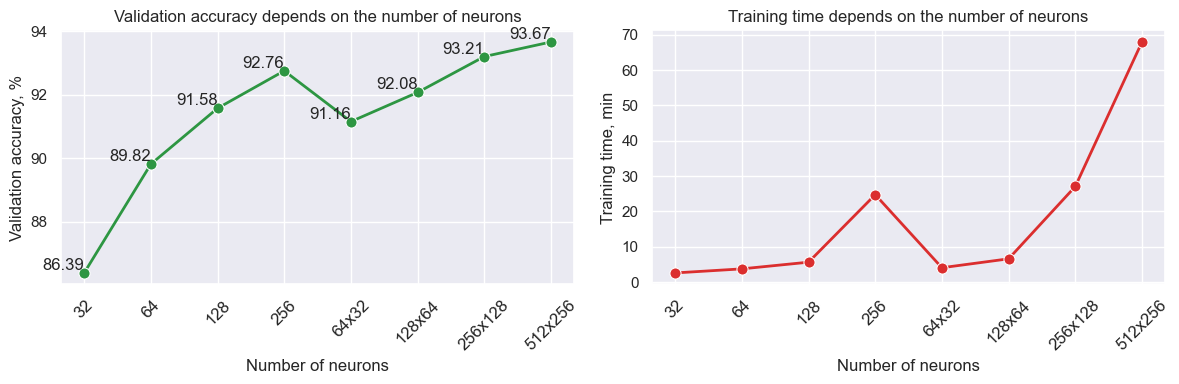

In [205]:
import seaborn as sns
%matplotlib inline

x_labels = ['32', '64', '128', '256', '64x32', '128x64', '256x128', '512x256']
x_numeric = range(len(x_labels))

sns.set(style='darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(ax=axes[0], x=x_numeric, y=y_valid_accs, marker='o', markersize=8, linewidth=2, color='#2d9642')
axes[0].set_xticks(x_numeric)
axes[0].set_xticklabels(x_labels, rotation=45, fontsize=12)
axes[0].set_xlabel('Number of neurons')
axes[0].set_ylabel('Validation accuracy, %')
axes[0].set_title('Validation accuracy depends on the number of neurons')
for i, txt in enumerate(y_valid_accs):
    axes[0].text(x_numeric[i], y_valid_accs[i], str(txt), fontsize=12, ha='right', va='bottom')

sns.lineplot(ax=axes[1], x=x_numeric, y=y_time, marker='o', markersize=8, linewidth=2, color='#db2e2e')
axes[1].set_xticks(x_numeric)
axes[1].set_xticklabels(x_labels, rotation=45, fontsize=12)
axes[1].set_xlabel('Number of neurons')
axes[1].set_ylabel('Training time, min')
axes[1].set_title('Training time depends on the number of neurons')

plt.tight_layout()
plt.show()

Из графиков можно сделать вывод, что, хоть и точность с наращиванием сложности сети растёт, это происходит очень медленно, а время обучения модели при этом растёт экспоненциально, а возможно и быстрее. 

Посмотрим на соотношения  $\frac{точность}{время\ обучения}$ для всех моделей:

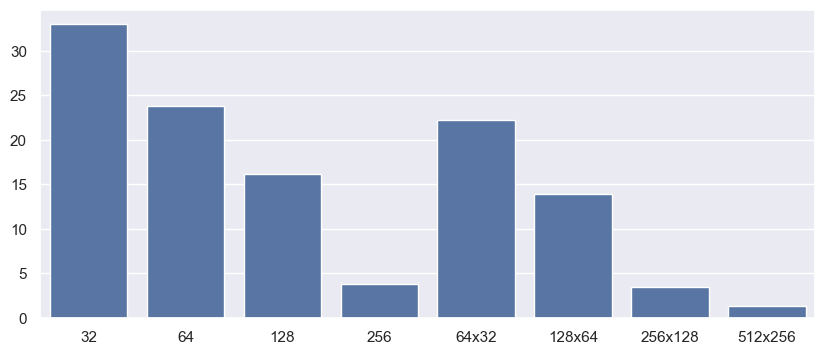

In [218]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
sns.barplot(x=x_numeric, y=np.array(y_valid_accs) / np.array(y_time))
plt.xticks(x_numeric, x_labels)
plt.show()

Выбор в пользу той или иной модели нужно делать исходя из задач, которые предстоит выполнять и имеющихся ресурсов.

In [229]:
def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)

    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label, pred_label] += 1

    return cm

In [233]:
with open('data/emnist/emnist-letters-mapping.txt', 'r') as mapping_file:
    idx = {}
    for line in mapping_file.readlines():
        items = line.split()
        idx[str(int(items[0])-1)] = int(items[1])

In [ ]:
import string

plt.figure(figsize=(10, 8))
labels = string.ascii_lowercase
for k, item in enumerate(experiment_data.items(), 1):
    model = item[1][0]
    predictions = [model.predict(x_test[i]) for i in range(len(x_test))]
    cm = confusion_matrix(y_test, predictions, num_classes)
    plt.subplot(2, 2, k)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix {k}')
    
plt.tight_layout()
plt.show()

In [199]:
def visualize(images, predictions, real, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f'Prediction: {chr(idx[str(predictions[i])])}\nActual: {chr(idx[str(real[i])])}')
        axes[i].axis('off')
    plt.show()

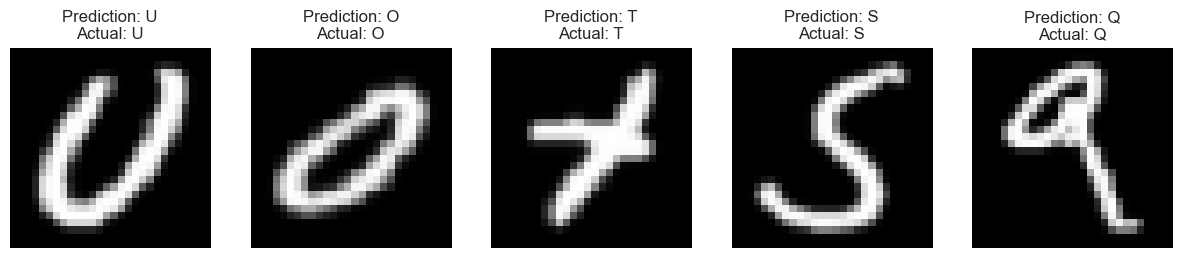

In [192]:
predictions = []
count = 5
x = []
y = []
for i in range(count):
    i_x = np.random.randint(0, x_valid.shape[0])
    x.append(x_valid[i_x])
    y.append(y_valid[i_x])
    predictions.append(model8.predict(x_valid[i_x]))
visualize(x, predictions, y, count)